# 1. Implementation of the Dataset and Preparation

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
import plotly.express as px
import pickle
import matplotlib.pyplot as plt
import os

# read dataset
df = pd.read_csv("ALLFLOWMETER_HIKARI2021.csv")

# extraction of the dataset labels
labels = df[['traffic_category', 'Label']].copy()
# droppping of unnecessary data
df_values = df.drop(columns=['uid', 'originh', 'originp', 'responh', 'responp','traffic_category', 'Label'])

# Scaling and Normalizing
scaler = preprocessing.StandardScaler().fit(df_values)
df_scaled = pd.DataFrame(scaler.transform(df_values))
df_normalized_l2 = pd.DataFrame(preprocessing.normalize(df_scaled, norm='l2'))
display(df_normalized_l2)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,-0.310656,-0.246514,-0.012507,-0.001262,-0.001871,-0.004779,-0.003762,-0.061547,-0.065765,-0.065101,...,0.030376,-0.002891,-0.034687,-0.038551,-0.015397,-0.038130,-0.019892,0.172732,0.271626,-0.073673
1,-0.295067,-0.234142,0.010572,-0.001199,-0.001777,-0.004539,-0.003574,-0.058658,-0.062669,-0.062041,...,-0.011653,0.000504,0.111868,0.075731,0.012368,0.100206,-0.018894,0.164065,0.257997,-0.069976
2,-0.294967,-0.234063,0.004846,-0.001565,-0.002139,-0.004538,-0.003937,-0.058632,-0.062642,-0.062013,...,-0.012100,-0.000167,0.079988,0.051002,0.006428,0.070174,-0.018888,0.164010,0.257911,-0.069953
3,-0.298415,-0.236798,0.001161,-0.001584,-0.002164,-0.004591,-0.003983,-0.059309,-0.063365,-0.062729,...,-0.012261,-0.000216,0.059838,0.035240,0.002573,0.051131,-0.019108,0.165928,0.260926,-0.070770
4,-0.301156,-0.238972,-0.002606,-0.001598,-0.001814,-0.004633,-0.004019,-0.059840,-0.063928,-0.063289,...,-0.012353,-0.000159,0.039060,0.019018,-0.001378,0.031510,-0.019284,0.167452,0.263324,-0.071421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555273,0.189944,0.157420,-0.010025,-0.004081,-0.004417,-0.010388,-0.003708,-0.037781,-0.040364,-0.039960,...,-0.009276,-0.001767,-0.021209,-0.023572,-0.009415,-0.023314,-0.012163,-0.107818,-0.079012,-0.045046
555274,0.189944,0.157421,-0.010025,-0.004081,-0.004417,-0.010388,-0.003708,-0.037781,-0.040364,-0.039960,...,-0.009276,-0.001767,-0.021209,-0.023572,-0.009415,-0.023314,-0.012163,-0.107818,-0.079012,-0.045046
555275,0.189945,0.157422,-0.010025,-0.004081,-0.004417,-0.010388,-0.003708,-0.037781,-0.040364,-0.039960,...,-0.009276,-0.001767,-0.021209,-0.023572,-0.009415,-0.023314,-0.012163,-0.107818,-0.079012,-0.045046
555276,0.189945,0.157423,-0.010025,-0.004081,-0.004417,-0.010388,-0.003708,-0.037781,-0.040364,-0.039960,...,-0.009276,-0.001767,-0.021209,-0.023572,-0.009415,-0.023314,-0.012163,-0.107818,-0.079012,-0.045046


## Label Distribution of the Dataset

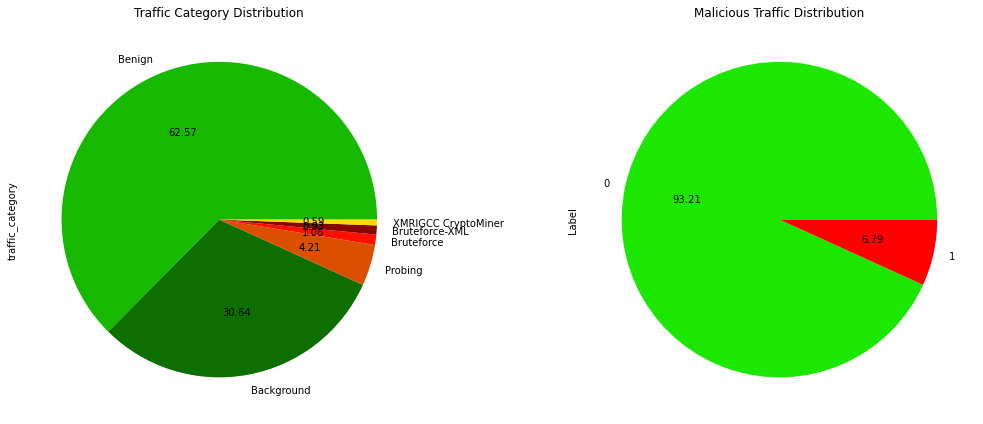

In [4]:
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#0D6F00", "#DA4F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution",
                                             colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution",
                                               colors=malicious_colors)

plt.tight_layout() 



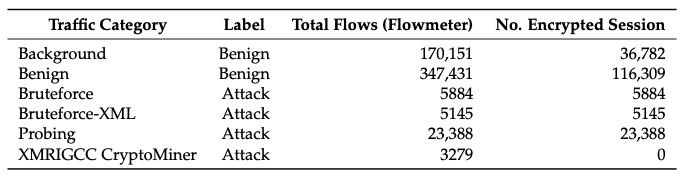

# Support Vector Machines Classification - Resampling

## Calculate the percentage distribution for the resampling

In [5]:
# Get the number of samples
samples_counter = labels['traffic_category'].count()
single_samples_counter = dict(labels['traffic_category'].value_counts())
non_mal_samples_counter = single_samples_counter['Benign'] + single_samples_counter['Background']
mal_samples_counter = single_samples_counter['Bruteforce'] + single_samples_counter['Bruteforce-XML'] + single_samples_counter['Probing'] + single_samples_counter['XMRIGCC CryptoMiner']
print(samples_counter, non_mal_samples_counter, mal_samples_counter)

# Get the percentage distribution of the traffic in non-malicious & malicious
non_mal_percentage = round(non_mal_samples_counter/samples_counter * 100, 2)
mal_percentage = 100 - non_mal_percentage
print(non_mal_percentage, mal_percentage)

# Get the percentage distribution of the non-malicious traffic
benign_percentage = round(single_samples_counter['Benign'] / non_mal_samples_counter * 100, 2)
background_percentage = 100 - benign_percentage
print(benign_percentage, background_percentage)

# Get the percentage distribution of the malicious traffic
bruteforce_percentage = round(single_samples_counter['Bruteforce'] / mal_samples_counter * 100, 2)
bruteforce_xml_percentage = round(single_samples_counter['Bruteforce-XML'] / mal_samples_counter * 100, 2)
probing_percentage = round(single_samples_counter['Probing'] / mal_samples_counter * 100, 2)
cryptominer_percentage = round(single_samples_counter['XMRIGCC CryptoMiner'] / mal_samples_counter * 100, 2)
print(bruteforce_percentage, bruteforce_xml_percentage, probing_percentage, cryptominer_percentage)

# calculate, on which size malicious and non-malicious must be sampled
percentage16_samples_counter = int(samples_counter * 0.16)
percentage24_samples_counter = int(samples_counter * 0.24)
percentage32_samples_counter = int(samples_counter * 0.32)
print(percentage16_samples_counter, percentage24_samples_counter, percentage32_samples_counter)


555278 517582 37696
93.21 6.790000000000006
67.13 32.870000000000005
15.61 13.65 62.04 8.7
88844 133266 177688


## Scale and Normalize the dataset

In [6]:
# Drop the unnecessary values
df_labels = df[['traffic_category', 'Label']].copy()
df_values = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp', 'traffic_category', 'Label'])

# Scaling and Normalizing
scaler = preprocessing.StandardScaler().fit(df_values)
df_scaled = pd.DataFrame(scaler.transform(df_values))

# Normalizing
df_normalized = pd.DataFrame(preprocessing.normalize(df_scaled, norm='l2'))

# concat the labels with the scaled&normalized data
df_normalized['traffic_category'] = df_labels['traffic_category']
df_normalized['Label'] = df_labels['Label']
display(df_normalized)

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
0,-0.013624,-0.001375,-0.002038,-0.005206,-0.004098,-0.067045,-0.071639,-0.070916,0.017689,-0.001908,...,-0.037785,-0.041995,-0.016773,-0.041536,-0.021669,0.188162,0.295889,-0.080253,Bruteforce-XML,1
1,0.011413,-0.001294,-0.001918,-0.004900,-0.003858,-0.063322,-0.067652,-0.066974,0.016650,-0.001546,...,0.120763,0.081753,0.013351,0.108173,-0.020396,0.177110,0.278511,-0.075540,Bruteforce-XML,1
2,0.005231,-0.001690,-0.002309,-0.004898,-0.004250,-0.063290,-0.067619,-0.066940,0.014933,-0.002129,...,0.086343,0.055054,0.006939,0.075750,-0.020388,0.177041,0.278402,-0.075510,Bruteforce-XML,1
3,0.001256,-0.001713,-0.002341,-0.004965,-0.004308,-0.064146,-0.068533,-0.067845,0.015137,-0.002158,...,0.064718,0.038114,0.002783,0.055301,-0.020667,0.179460,0.282206,-0.076542,Bruteforce-XML,1
4,-0.002823,-0.001731,-0.001965,-0.005019,-0.004354,-0.064822,-0.069251,-0.068558,0.041590,-0.002181,...,0.042312,0.020601,-0.001493,0.034133,-0.020889,0.181393,0.285246,-0.077367,Bruteforce-XML,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555273,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555274,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555275,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1
555276,-0.010345,-0.004211,-0.004558,-0.010720,-0.003827,-0.038986,-0.041651,-0.041234,-0.196148,-0.004033,...,-0.021885,-0.024323,-0.009715,-0.024058,-0.012551,-0.111257,-0.081532,-0.046483,XMRIGCC CryptoMiner,1


## Split the dataset into a training and test set

In [7]:
# Split the dataset
# --> df_train is the data, which will be resampled
df_train, x_test, y_train, y_test = train_test_split(df_normalized, labels['Label'], test_size=0.2)

# Drop any identifier from the test dataset
x_test = x_test.drop(columns=['traffic_category', 'Label'])
x_test

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
438477,-0.020785,-0.004176,-0.002945,-0.015824,-0.003915,-0.079099,-0.083907,-0.083367,0.189206,-0.004099,...,-0.012246,-0.003778,-0.045340,-0.050391,-0.020126,-0.049841,-0.026001,0.225782,0.355048,-0.087785
167477,-0.011091,-0.008158,-0.008989,-0.014294,-0.007268,-0.091359,-0.097615,-0.096632,-0.071028,-0.009094,...,0.131695,-0.004276,-0.051309,-0.057025,-0.022776,-0.056402,-0.029424,-0.260836,-0.191147,-0.108976
520669,-0.028786,-0.011069,-0.011370,-0.025609,-0.009325,-0.103738,-0.110680,-0.109646,0.069717,-0.011109,...,-0.025793,-0.005088,-0.061061,-0.067864,-0.027105,-0.067123,-0.035017,-0.310413,-0.227478,-0.129689
292740,-0.020632,-0.007933,-0.008149,-0.018354,-0.006684,-0.074299,-0.079269,-0.078529,0.049967,-0.007962,...,-0.018495,-0.003647,-0.043763,-0.048638,-0.019426,-0.048107,-0.025097,-0.222475,-0.163035,-0.092949
40537,-0.022534,-0.009173,-0.009928,-0.023350,-0.008335,-0.084920,-0.090724,-0.089816,-0.427247,-0.008784,...,-0.020848,-0.003973,-0.047670,-0.052981,-0.021161,-0.052403,-0.027338,-0.242338,-0.177592,-0.101248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397605,-0.028788,-0.011070,-0.011371,-0.025610,-0.009326,-0.103664,-0.110598,-0.109566,0.069719,-0.011109,...,-0.025807,-0.005089,-0.061063,-0.067866,-0.027106,-0.067125,-0.035018,-0.310422,-0.227485,-0.129693
400039,-0.028783,-0.011069,-0.011370,-0.025609,-0.009325,-0.103849,-0.110802,-0.109765,0.069716,-0.011109,...,-0.025772,-0.005088,-0.061060,-0.067863,-0.027104,-0.067122,-0.035016,-0.310408,-0.227475,-0.129688
174675,-0.025133,-0.009664,-0.009926,-0.022357,-0.008141,-0.090365,-0.096405,-0.095508,0.060863,-0.009698,...,-0.022552,-0.004442,-0.053306,-0.059245,-0.023663,-0.058598,-0.030570,-0.270991,-0.198589,-0.113219
17339,-0.022222,-0.009652,-0.009914,-0.022330,-0.008131,-0.094742,-0.101215,-0.100202,0.060788,-0.009686,...,0.011203,-0.004437,-0.053240,-0.059172,-0.023633,-0.058526,-0.030532,-0.270656,-0.198344,-0.113079


## Resample the traffic categories to 16%

59640 29203 13868 12127 55118 7729


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
305358,-0.028102,-0.011473,-0.011759,-0.029203,-0.009765,-0.103865,-0.110895,-0.109819,0.068072,-0.010986,...,-0.059620,-0.066262,-0.026465,-0.065538,-0.034190,-0.303086,-0.222109,-0.126628,Benign,0
312695,-0.028294,-0.011156,-0.011459,-0.025810,-0.009398,-0.109127,-0.116571,-0.115411,0.070264,-0.011196,...,-0.061540,-0.068396,-0.027317,-0.067649,-0.035291,-0.312847,-0.229263,-0.130707,Benign,0
274612,-0.026599,-0.010229,-0.010507,-0.023665,-0.008617,-0.095918,-0.102338,-0.101381,0.064423,-0.010265,...,-0.056424,-0.062710,-0.025047,-0.062026,-0.032358,-0.286841,-0.210205,-0.119842,Benign,0
275461,-0.021819,-0.008391,-0.008619,-0.019412,-0.007069,-0.078680,-0.083946,-0.083162,0.052846,-0.008420,...,-0.046284,-0.051441,-0.020546,-0.050879,-0.026543,-0.235293,-0.172429,-0.098305,Benign,0
521143,-0.022768,-0.009269,-0.010031,-0.023592,-0.008422,-0.085803,-0.091668,-0.090749,-0.431690,-0.008876,...,-0.048166,-0.053532,-0.021381,-0.052948,-0.027622,-0.244858,-0.179438,-0.102301,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552368,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552533,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
554069,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553250,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


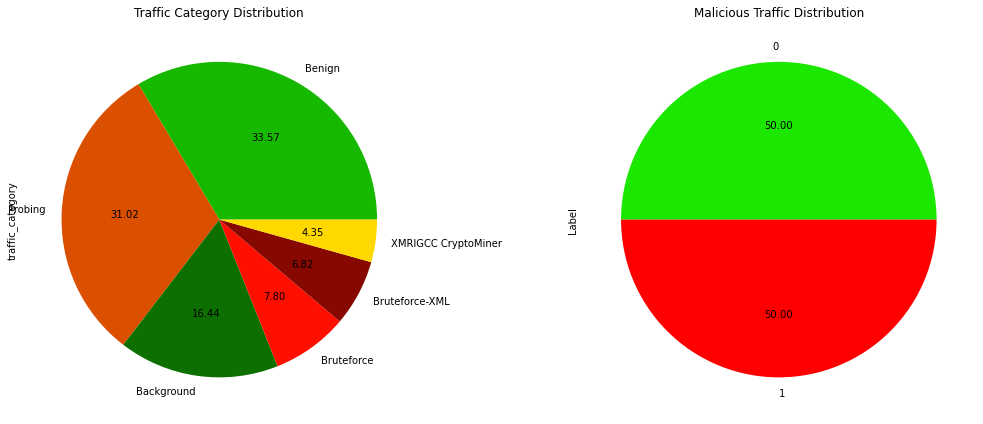

In [13]:
# Get the number of samples, every subset must be down-/upsampled
benign_sample_number = int(percentage16_samples_counter * (benign_percentage / 100))
background_sample_number = int(percentage16_samples_counter * (background_percentage / 100))
bruteforce_sample_number = int(percentage16_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_sample_number = int(percentage16_samples_counter * (bruteforce_xml_percentage / 100))
probing_sample_number = int(percentage16_samples_counter * (probing_percentage / 100)) 
cryptominer_sample_number = int(percentage16_samples_counter * (cryptominer_percentage / 100))
print(benign_sample_number, background_sample_number, bruteforce_sample_number, bruteforce_xml_sample_number, probing_sample_number, cryptominer_sample_number)


# Sample the dataset
from sklearn.utils import resample
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_sample_number, random_state=42)

# Concat the dataset
df_16 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_16)

# Show the new distribution
labels = df_16[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.tight_layout() 

## Prepare the test data

In [10]:
# create a test set with the labels
y_train = df_16['Label'].copy()

# create a test set with the values and without any identifier
x_train = df_16.drop(columns=['traffic_category', 'Label'])

print("Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

Training set shape:(177685, 79)
Test set shape:(111056, 79)


## Create a SVC Model with 16% resampled data

In [11]:
if not os.path.exists('svc_models/traffic_analysis_16_balance_svc.model'):
    clf_16_balancing = SVC(gamma='auto')
    clf_16_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_16_balance_svc', 'wb') as handle:
        pickle.dump(clf_16_balancing, handle)

## Test the 16% SVC Model

In [12]:
# Load SVC Model from the previous step
with open('svc_models/traffic_analysis_16_balance_svc.model', 'rb') as handle:
    clf_16_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_16_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    103497
           1       0.26      0.90      0.40      7559

    accuracy                           0.82    111056
   macro avg       0.62      0.85      0.64    111056
weighted avg       0.94      0.82      0.86    111056



## Resample the traffic categories to 24%

89461 43804 20802 18190 82678 11594


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
305358,-0.028102,-0.011473,-0.011759,-0.029203,-0.009765,-0.103865,-0.110895,-0.109819,0.068072,-0.010986,...,-0.059620,-0.066262,-0.026465,-0.065538,-0.034190,-0.303086,-0.222109,-0.126628,Benign,0
312695,-0.028294,-0.011156,-0.011459,-0.025810,-0.009398,-0.109127,-0.116571,-0.115411,0.070264,-0.011196,...,-0.061540,-0.068396,-0.027317,-0.067649,-0.035291,-0.312847,-0.229263,-0.130707,Benign,0
274612,-0.026599,-0.010229,-0.010507,-0.023665,-0.008617,-0.095918,-0.102338,-0.101381,0.064423,-0.010265,...,-0.056424,-0.062710,-0.025047,-0.062026,-0.032358,-0.286841,-0.210205,-0.119842,Benign,0
275461,-0.021819,-0.008391,-0.008619,-0.019412,-0.007069,-0.078680,-0.083946,-0.083162,0.052846,-0.008420,...,-0.046284,-0.051441,-0.020546,-0.050879,-0.026543,-0.235293,-0.172429,-0.098305,Benign,0
521143,-0.022768,-0.009269,-0.010031,-0.023592,-0.008422,-0.085803,-0.091668,-0.090749,-0.431690,-0.008876,...,-0.048166,-0.053532,-0.021381,-0.052948,-0.027622,-0.244858,-0.179438,-0.102301,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553664,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553301,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553064,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
552297,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


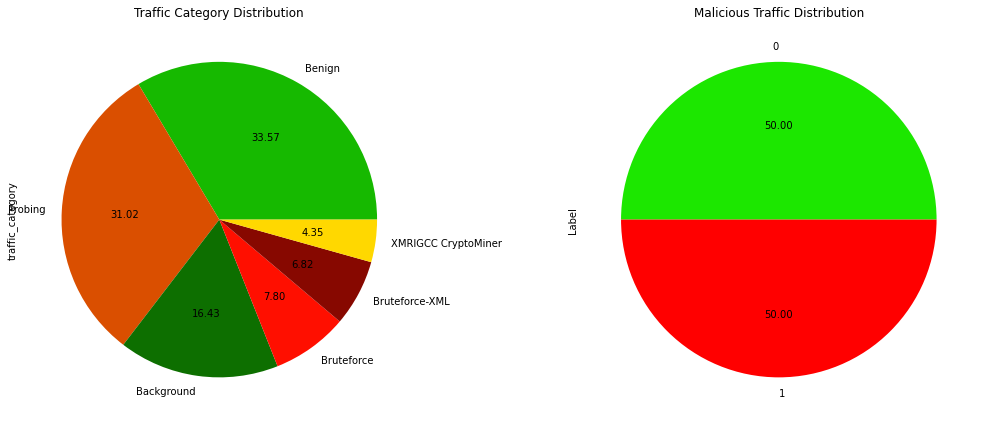

In [14]:
# Get the number of samples, every subset must be down-/upsampled
benign_24_sample_number = int(percentage24_samples_counter * (benign_percentage / 100))
background_24_sample_number = int(percentage24_samples_counter * (background_percentage / 100))
bruteforce_24_sample_number = int(percentage24_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_24_sample_number = int(percentage24_samples_counter * (bruteforce_xml_percentage / 100))
probing_24_sample_number = int(percentage24_samples_counter * (probing_percentage / 100)) 
cryptominer_24_sample_number = int(percentage24_samples_counter * (cryptominer_percentage / 100))
print(benign_24_sample_number, background_24_sample_number, bruteforce_24_sample_number, bruteforce_xml_24_sample_number, probing_24_sample_number, cryptominer_24_sample_number)


# Sample the dataset
from sklearn.utils import resample
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_24_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_24_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_24_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_24_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_24_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_24_sample_number, random_state=42)

# Concat the dataset
df_24 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_24)

# Show the new distribution
labels = df_24[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.tight_layout() 

## Prepare the test data

In [16]:
# create a test set with the labels
y_train = df_24['Label'].copy()

# create a test set with the values and without any identifier
x_train = df_24.drop(columns=['traffic_category', 'Label'])

print("Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

Training set shape:(266529, 79)
Test set shape:(111056, 79)


## Create a SVC Model with 24% resampled data

In [17]:
if not os.path.exists('svc_models/traffic_analysis_24_balance_svc.model'):
    clf_24_balancing = SVC(gamma='auto')
    clf_24_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_24_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_24_balancing, handle)

## Test the 24% SVC Model

In [20]:
# Load SVC Model from the previous step
with open('svc_models/traffic_analysis_24_balance_svc.model', 'rb') as handle:
    clf_24_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_24_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    103497
           1       0.26      0.90      0.40      7559

    accuracy                           0.82    111056
   macro avg       0.63      0.86      0.65    111056
weighted avg       0.94      0.82      0.86    111056



## Resample the traffic categories to 32%

119281 58406 27737 24254 110237 15458


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,traffic_category,Label
495953,-0.018961,-0.007719,-0.008354,-0.022472,-0.007014,-0.071455,-0.076340,-0.075575,-0.359505,-0.007015,...,-0.040112,-0.044581,-0.017806,-0.044094,-0.023003,0.199747,-0.149434,0.461926,Benign,0
199430,-0.020521,-0.007891,-0.008105,-0.018256,-0.006648,-0.073929,-0.078875,-0.078139,0.049699,-0.007919,...,-0.043528,-0.048378,-0.019322,-0.047850,-0.024962,-0.221283,-0.162162,-0.092452,Benign,0
503837,-0.026767,-0.010927,-0.011200,-0.027815,-0.009301,-0.098923,-0.105618,-0.104593,0.064836,-0.010464,...,-0.056786,-0.063113,-0.025207,-0.062424,-0.032565,-0.288681,-0.211553,-0.120610,Benign,0
215438,-0.018791,-0.002038,-0.003257,-0.008926,-0.005125,-0.075456,-0.080731,-0.079864,-0.012935,-0.002266,...,-0.042873,-0.047649,-0.019031,-0.047129,-0.024586,0.213497,0.338581,-0.089297,Benign,0
526653,-0.022768,-0.009269,-0.010031,-0.023592,-0.008422,-0.085803,-0.091668,-0.090749,-0.431690,-0.008876,...,-0.048166,-0.053532,-0.021381,-0.052948,-0.027622,-0.244858,-0.179438,-0.102301,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552838,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553575,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553208,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047374,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1
553354,-0.018715,-0.008060,-0.009866,-0.016533,-0.008283,-0.084295,-0.090160,-0.089205,-0.424589,-0.008507,...,-0.047373,-0.052651,-0.021029,-0.052077,-0.027167,-0.240831,-0.176487,-0.100618,XMRIGCC CryptoMiner,1


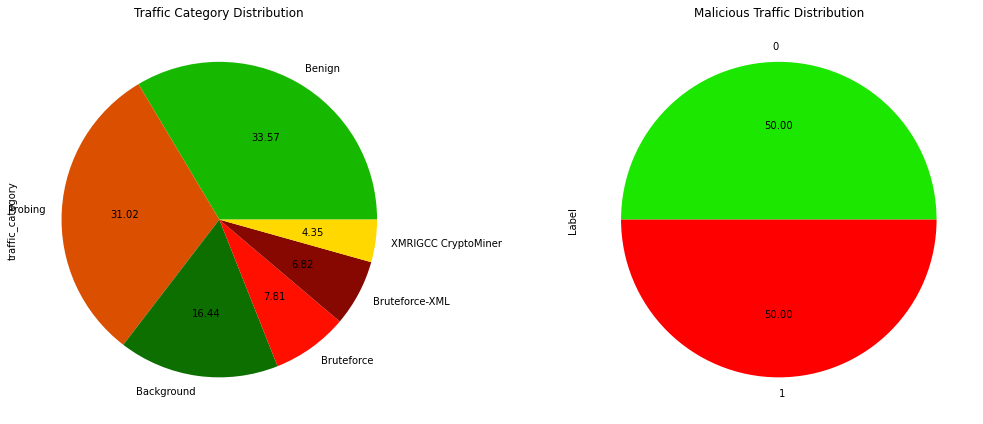

In [9]:
# Get the number of samples, every subset must be down-/upsampled
benign_32_sample_number = int(percentage32_samples_counter * (benign_percentage / 100))
background_32_sample_number = int(percentage32_samples_counter * (background_percentage / 100))
bruteforce_32_sample_number = int(percentage32_samples_counter * (bruteforce_percentage / 100))
bruteforce_xml_32_sample_number = int(percentage32_samples_counter * (bruteforce_xml_percentage / 100))
probing_32_sample_number = int(percentage32_samples_counter * (probing_percentage / 100)) 
cryptominer_32_sample_number = int(percentage32_samples_counter * (cryptominer_percentage / 100))
print(benign_32_sample_number, background_32_sample_number, bruteforce_32_sample_number, bruteforce_xml_32_sample_number, probing_32_sample_number, cryptominer_32_sample_number)


# Sample the dataset
from sklearn.utils import resample
bening_entries = df_train[df_train['traffic_category'] == "Benign"]
benign_sampling = resample(bening_entries, n_samples=benign_32_sample_number, random_state=42)

background_entries = df_train[df_train['traffic_category'] == "Background"]
background_sampling = resample(background_entries, n_samples=background_32_sample_number, random_state=42)

bruteforce_entries = df_train[df_train['traffic_category'] == "Bruteforce"]
bruteforce_sampling = resample(bruteforce_entries, n_samples=bruteforce_32_sample_number, random_state=42)

bruteforce_xml_entries = df_train[df_train['traffic_category'] == "Bruteforce-XML"]
bruteforce_xml_sampling = resample(bruteforce_xml_entries, n_samples=bruteforce_xml_32_sample_number, random_state=42)

probing_entries = df_train[df_train['traffic_category'] == "Probing"]
probing_sampling = resample(probing_entries, n_samples=probing_32_sample_number, random_state=42)

cryptominer_entries = df_train[df_train['traffic_category'] == "XMRIGCC CryptoMiner"]
cryptominer_sampling = resample(cryptominer_entries, n_samples=cryptominer_32_sample_number, random_state=42)

# Concat the dataset
df_32 = pd.concat([benign_sampling, background_sampling, bruteforce_sampling, bruteforce_xml_sampling, probing_sampling, cryptominer_sampling])
display(df_32)

# Show the new distribution
labels = df_32[['traffic_category', 'Label']].copy()
traffic_distribution = labels['traffic_category']
malicious_distribution= labels['Label']

traffic_colors = ["#16B900", "#DA4F00", "#0D6F00", "#FF0F00", "#870800", "#FFD800"]
malicious_colors = ["#1CE700", "#FF0000"]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns
traffic_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax1, title="Traffic Category Distribution", colors=traffic_colors)
malicious_distribution.value_counts().plot.pie(autopct='%.2f', ax=ax2, title="Malicious Traffic Distribution", colors=malicious_colors)

plt.tight_layout() 

## Prepare the test data

In [10]:
# create a test set with the labels
y_train = df_32['Label'].copy()

# create a test set with the values and without any identifier
x_train = df_32.drop(columns=['traffic_category', 'Label'])

print("Training set shape:" + str(x_train.shape))
print("Test set shape:" + str(x_test.shape))

Training set shape:(355373, 79)
Test set shape:(111056, 79)


## Create a SVC Model with 32% resampled data

In [11]:
if not os.path.exists('svc_models/traffic_analysis_32_balance_svc.model'):
    clf_32_balancing = SVC(gamma='auto')
    clf_32_balancing.fit(x_train, y_train)
    with open('svc_models/traffic_analysis_32_balance_svc.model', 'wb') as handle:
        pickle.dump(clf_32_balancing, handle)

## Test the 32% SVC Model

In [24]:
with open('svc_models/traffic_analysis_32_balance_svc.model', 'rb') as handle:
    clf_32_balancing = pickle.load(handle)

# Test the no balancing SVC Model
pred_labels = clf_32_balancing.predict(x_test)
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89    103497
           1       0.27      0.99      0.43      7559

    accuracy                           0.82    111056
   macro avg       0.64      0.90      0.66    111056
weighted avg       0.95      0.82      0.86    111056



# Create a SVC Model with the non-malicious data downsampled to the size of the malicious data 

## Resample the the non-malicious traffic categories

In [8]:
# Size of all malicious traffic categories
mal_samples_counter

37696

In [ ]:
# ToDo resampling - not implemented so far